# Homework

**Name:** Thaweewat Rugsujarit
**Email:** 65056039@kmitl.ac.th

**Goal:** Goal of this homework is to understand the data and create visualization to explain the insights to owner of the coffee shop
also make business suggestion to improve the business from data insights.

1. Generate the dataset: Name your file YYMMDDYourName.csv
2. Understand Data
    1. EDA the data for your understanding
        - start with questions and find answer
        - explore the data and find insights
3. Create Visualization to explain the insights to owner of the coffee shop
    1. explain top 5 what you're finding
    2. recommend how to improve from data insights
        - Launch marketing campaign (coupon, breakfast set, buy 1, get 1, anything relate to Gas purchase)
        - Reduce staff (Assumption: 2 staff per day)

**Tools:** Any tools : Excel, Python , any BI Tools

In [1]:
import csv
import random
import polars as pl
import pandas as pd
from datetime import datetime, timedelta

# import visualization library
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set pandas decimal precision to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

### Generate Transaction Datasets

In [2]:
# Set the seed value
random.seed(65056039)

# List of items available in the coffee shop and gas station
items = {
    'coffee': ['coffee1', 'coffee2', 'coffee3', 'coffee4'],
    'drinks': ['drink1', 'drink2', 'drink3'],
    'bakery': [f'bakery{n}' for n in range(1, 11)],
    'gas': ['X1', 'P1'],
}

# List of payment methods
payment_methods = ['cash', 'credit card', 'qr code']

# Function to generate a random transaction
def generate_transaction():
    """
    Faker Dataset Generator
    :return:
    """
    date = datetime.now() - timedelta(days=random.randint(0, 365))
    date = date.strftime('%m-%d-%Y')

    item_type = random.choice(list(items.keys()))
    item = random.choice(items[item_type])

    quantity = random.randint(1, 10)

    discount = round(random.uniform(0, 1), 2)  # Random discount between 0 and 1
    unit_price = round(random.uniform(1, 20), 2)  # Random price between 1 and 20
    total_price = round(quantity * unit_price * (1 - discount), 2)

    payment_method = random.choice(payment_methods)

    return [date, item_type, item, quantity, unit_price, discount, total_price, payment_method]

# Create CSV file
with open('transactions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Date", "Item Type", "Item", "Quantity", "Unit Price", "Discount", "Total Price", "Payment Method"])
    for _ in range(100 * 365):  # Average 100 transactions per day for a year
        writer.writerow(generate_transaction())

print("CSV file created successfully.")

CSV file created successfully.


## Understanding Transaction Dataset

### Import Dataset

In [3]:
# Import dataset
transactions_raw = (
    pl.scan_csv("transactions.csv")
    .with_columns(pl.col("Date")
                  .str.strptime(pl.Datetime, '%m-%d-%Y', strict=False)
                  .cast(pl.Date))
    .collect()
    .to_pandas()
)

# Show first 5 rows
transactions_raw.head(5)

,Date,Item Type,Item,Quantity,Unit Price,Discount,Total Price,Payment Method
0,2023-07-22,coffee,coffee1,5,13.20,0.40,39.60,credit card
1,2023-03-02,drinks,drink1,4,9.40,0.39,22.94,qr code
2,2023-02-20,coffee,coffee3,7,10.50,0.17,61.00,credit card
3,2023-01-15,drinks,drink3,5,7.27,0.80,7.27,qr code
4,2023-01-25,drinks,drink1,5,3.76,0.52,9.02,cash


### Transaction Dataset Summary

#### Data Dictionary

This coffee shop transaction dataset has total **36,500 rows** of transaction
under the period of 1 year start between **2022-07-15 to 2023-07-15**

the columns are:
1. **Date:** Date of that transaction
2. **Item Type:** Type of product customer brought
3. **Item:** Item name that customer brought
4. **Quantity:** Total unit of item customer brought
5. **Unit Price:** Price per unit of those/that item
6. **Total Price:** Total sum of that transaction
7. **Payment Method:** Payment method that customer used to pay for that transaction

In [4]:
# Find Period of Transaction
print(f"First Transaction: {transactions_raw['Date'].min()}")
print(f"Last Transaction: {transactions_raw['Date'].max()}")
# Find Total Transaction

First Transaction: 2022-07-22 00:00:00
Last Transaction: 2023-07-22 00:00:00


In [5]:
# describe but exclude date columns
(transactions_raw
.describe(include='number')
.T[['count', 'mean','50%', 'std', 'min', 'max']])

,count,mean,50%,std,min,max
Quantity,36500.00,5.51,6.00,2.86,1.00,10.00
Unit Price,36500.00,10.47,10.51,5.49,1.00,20.00
Discount,36500.00,0.50,0.50,0.29,0.00,1.00
Total Price,36500.00,28.69,17.46,30.97,0.00,197.70


### Data Preprocessing

#### Columns Name Cleaning

In columns name there are some space between the words and mix of upper and lower case.
So we need to fix it first.

In [6]:
# Fix column name for readability
transactions_raw.columns = transactions_raw.columns.str.lower().str.replace(' ', '_')
print(f"Columns name after cleaning: {transactions_raw.columns.tolist()}")

Columns name after cleaning: ['date', 'item_type', 'item', 'quantity', 'unit_price', 'discount', 'total_price', 'payment_method']


#### Add Transaction ID

This transaction dataset doesn't have transaction id, so we need to add it as well.

In [7]:
# Add transaction_id column
transactions_raw = (transactions_raw
                    .sort_values('date')
                    .reset_index(drop=True)
                    .assign(transaction_id=lambda x: (x.index + 1)
                            .astype(str).str.zfill(6)))

# Show first 5 rows
transactions_raw.head(5)

,date,item_type,item,quantity,unit_price,discount,total_price,payment_method,transaction_id
0,2022-07-22,coffee,coffee3,9,19.04,0.08,157.65,credit card,000001
1,2022-07-22,coffee,coffee1,3,17.79,0.44,29.89,credit card,000002
2,2022-07-22,gas,X1,6,3.60,0.89,2.38,cash,000003
3,2022-07-22,bakery,bakery10,4,19.57,0.32,53.23,credit card,000004
4,2022-07-22,gas,X1,6,14.10,0.70,25.38,credit card,000005


#### Validate the calculation of total price

According to total price, it supposed to be the multiplication of quantity, unit price, and discount rate.

In [8]:
# check total price calculation
def check_formula(transaction_df: pd.DataFrame) -> None:
    """
    Check total price calculation
    :param transaction_df: transaction dataframe
    :return: if there is any wrong calculation, it will print the number of rows and the rows
    """
    total_unequal_row = (len(transaction_df
                           .assign(total_price_calc=lambda x: x['quantity'] * x['unit_price'] * (1 - x['discount']))
                           .round(2)
                           .query('total_price != total_price_calc')
    ))
    if total_unequal_row != 0:
        print(f"Number of rows with wrong total price calculation: {total_unequal_row} rows")
        return (
            transactions_raw
            .assign(total_price_calc=lambda x: x['quantity'] * x['unit_price'] * (1 - x['discount']))
            .round(2)
            .assign(total_price_diff=lambda x: x['total_price'] - x['total_price_calc'])
            .query('total_price != total_price_calc')
            [['quantity', 'unit_price', 'discount', 'total_price', 'total_price_calc', 'total_price_diff']]
        )
    else:
	    print(f"Correct calculation on every rows!")

In [9]:
# check total price calculation
check_formula(transactions_raw)

Number of rows with wrong total price calculation: 295 rows


,quantity,unit_price,discount,total_price,total_price_calc,total_price_diff
293,2,13.05,0.65,9.13,9.14,-0.01
305,5,18.95,0.30,66.33,66.32,0.01
502,5,2.19,0.70,3.29,3.28,0.01
506,2,5.15,0.05,9.79,9.78,0.01
754,3,17.37,0.50,26.05,26.06,-0.01
...,...,...,...,...,...,...
36092,10,17.53,0.75,43.83,43.82,0.01
36145,5,1.35,0.86,0.95,0.94,0.01
36177,5,2.58,0.05,12.25,12.26,-0.01
36306,7,8.75,0.06,57.57,57.58,-0.01


It is possible to have small calculation errors when working with **floating-point numbers in Python**. Floating-point numbers have limited precision and may not be able to represent certain decimal values exactly. This can lead to small rounding errors or discrepancies in calculations.

If we need precise decimal calculations, we can consider using the `decimal` module in Python, which provides support for decimal arithmetic with adjustable precision but the dataset already generated, so we will just calculate the total price again with **the same formula but fixing all variables to 2 decimal places.**

In [10]:
# Recalculate total price
transactions_cleaned = (transactions_raw
                    .assign(total_price=lambda x: x['quantity'] * x['unit_price'] * (1 - x['discount']))
                    .round(2))

check_formula(transactions_cleaned)

Correct calculation on every rows!


#### Add Year and Month Column for EDA

We will add year. month and weekday columns for easier to do EDA later.

In [11]:
# Add year, month and weekday column
transactions_cleaned = (transactions_cleaned
                    .assign(year=lambda x: x['date'].dt.year)
                    .assign(month=lambda x: x['date'].dt.month)
                    .assign(year_month=lambda x: x['date'].dt.strftime('%Y-%m'))
                    .assign(weekday=lambda x: x['date'].dt.strftime('%A')))

# Show first 5 rows
transactions_cleaned.head(5)

,date,item_type,item,quantity,unit_price,discount,total_price,payment_method,transaction_id,year,month,year_month,weekday
0,2022-07-22,coffee,coffee3,9,19.04,0.08,157.65,credit card,000001,2022,7,2022-07,Friday
1,2022-07-22,coffee,coffee1,3,17.79,0.44,29.89,credit card,000002,2022,7,2022-07,Friday
2,2022-07-22,gas,X1,6,3.60,0.89,2.38,cash,000003,2022,7,2022-07,Friday
3,2022-07-22,bakery,bakery10,4,19.57,0.32,53.23,credit card,000004,2022,7,2022-07,Friday
4,2022-07-22,gas,X1,6,14.10,0.70,25.38,credit card,000005,2022,7,2022-07,Friday


## Exploratory Data Analysis

### Overview on transaction sold (quantity and total price)

In [12]:
print(f"There are {transactions_cleaned['item'].nunique()} SKU sold in total")
print(f"From total type of {transactions_cleaned['item_type'].nunique()} item type")

There are 19 SKU sold in total
From total type of 4 item type


In [13]:
# Show top item sold
(
    transactions_cleaned
        .groupby(['item', 'item_type'])
        .agg({'quantity': 'sum', 'total_price': 'sum'})
        .reset_index()
        .sort_values('quantity', ascending=False)
        .head(transactions_cleaned['item'].nunique())
)

,item,item_type,quantity,total_price
1,X1,gas,25430,134738.61
0,P1,gas,24217,126002.45
17,drink2,drinks,16838,84773.01
16,drink1,drinks,16676,86694.84
18,drink3,drinks,16636,85095.88
14,coffee3,coffee,12901,67890.57
12,coffee1,coffee,12894,66284.45
15,coffee4,coffee,12783,67889.37
13,coffee2,coffee,12539,66409.22
7,bakery5,bakery,5451,29081.04


Text(0.5, 1.0, 'Total Sales per Item (Baht)')

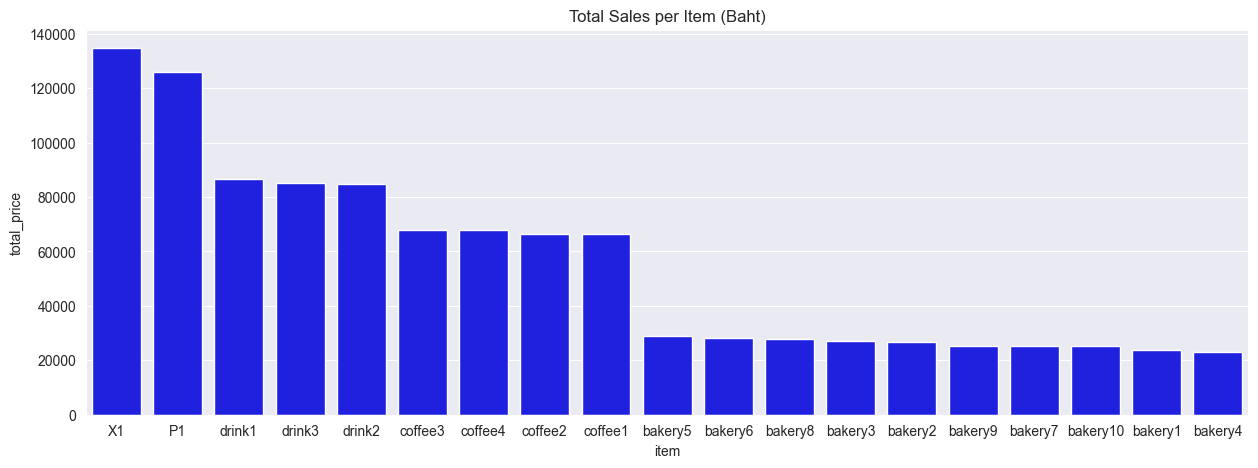

In [82]:
# Plot bar chart of sum total price per item
sorted_data = (
	transactions_cleaned
	.pivot_table(index=['item_type','item']
	             , values='total_price'
	             , aggfunc='sum')
	.reset_index()
	.sort_values('total_price', ascending=False)
)

plt.figure(figsize=(15, 5))
sns.barplot(data=sorted_data
            , x='item'
            , y='total_price'
            , color='blue')

plt.title('Total Sales per Item (Baht)')

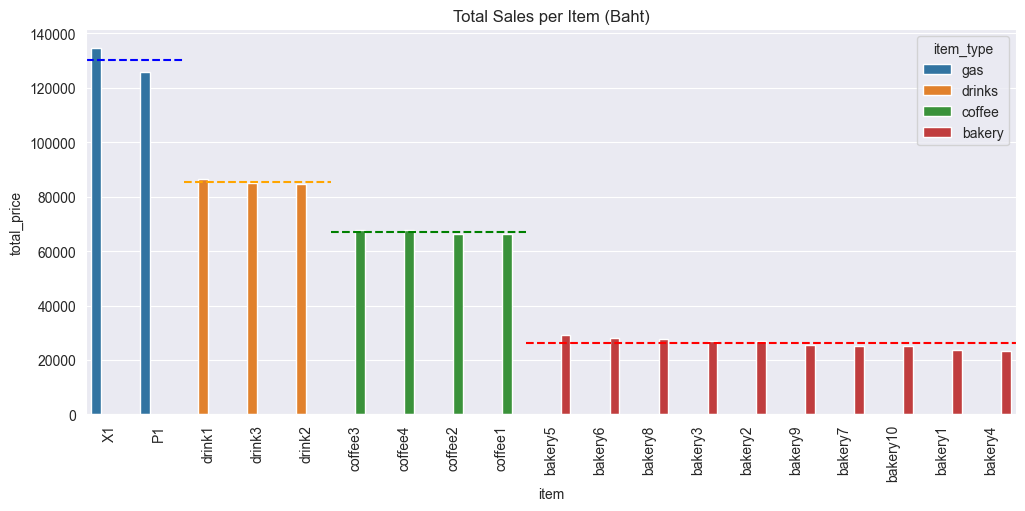

In [75]:
# Plot bar chart of sum total price per item
sorted_data = (
    transactions_cleaned
        .pivot_table(index=['item_type','item']
                     , values='total_price'
                     , aggfunc='sum')
        .reset_index()
        .sort_values('total_price', ascending=False)
)

plt.figure(figsize=(12, 5))
sns.barplot(data=sorted_data
            , x='item'
            , y='total_price'
            , hue='item_type')
plt.title('Total Sales per Item (Baht)')

plt.axhline(y=sorted_data
            .groupby('item_type')
            .agg({'total_price': 'mean'})
            .reset_index()
            .query('item_type == "gas"')['total_price'].values[0]
            , xmin=0/len(sorted_data)
            , xmax=2/len(sorted_data)
            , color='blue'
            , linestyle='--')

plt.axhline(y=sorted_data
            .groupby('item_type')
            .agg({'total_price': 'mean'})
            .reset_index()
            .query('item_type == "drinks"')['total_price'].values[0]
            , xmin=2/len(sorted_data)
            , xmax=5/len(sorted_data)
            , color='orange'
            , linestyle='--')

plt.axhline(y=sorted_data
            .groupby('item_type')
            .agg({'total_price': 'mean'})
            .reset_index()
            .query('item_type == "coffee"')['total_price'].values[0]
            , xmin=5/len(sorted_data)
            , xmax=9/len(sorted_data)
            , color='green'
            , linestyle='--')

plt.axhline(y=sorted_data
            .groupby('item_type')
            .agg({'total_price': 'mean'})
            .reset_index()
            .query('item_type == "bakery"')['total_price'].values[0]
            , xmin=9/len(sorted_data)
            , xmax=19/len(sorted_data)
            , color='red'
            , linestyle='--')

plt.xticks(rotation=90)
plt.show()

This seems like gas this the top product sale in this coffee shop, followed by drinks and coffee. but if we actually look at the total quantity sold by types all of these types have similar total quantity sold that divide equally to each SKU.

In [15]:
# Show top 10 item sold
(
    transactions_cleaned
        .groupby(['item_type'])
        .agg({'quantity': 'sum', 'total_price': 'sum'})
        .reset_index()
        .sort_values('quantity', ascending=False)
        .head(transactions_cleaned['item_type'].nunique())
 )

,item_type,quantity,total_price
1,coffee,51117,268473.61
0,bakery,50199,261441.99
2,drinks,50150,256563.73
3,gas,49647,260741.06


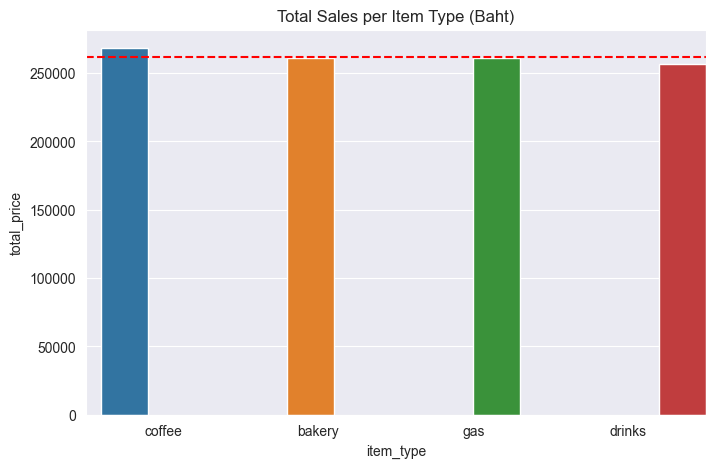

In [16]:
# Plot bar chart of sum total price per item
sorted_data = (
	transactions_cleaned
	.pivot_table(index=['item_type'], values='total_price', aggfunc='sum')
	.reset_index()
	.sort_values('total_price', ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(data=sorted_data, x='item_type', y='total_price', hue='item_type')
for patch in plt.gca().patches:
	patch.set_width(0.3)

plt.axhline(y=transactions_cleaned
            .groupby(['item_type'])
            .agg({'total_price': 'sum'})
            .mean()[0]
            , xmin=0/len(sorted_data)
            , xmax=4/len(sorted_data)
            , color='red'
            , linestyle='--')

plt.title('Total Sales per Item Type (Baht)')
plt.legend([],[], frameon=False)
plt.show()

Based on what we know so far, every product type sold by this coffee shop in the period of one year have the same total quantity sold and total price sold. To prove that every product have the same demand we have to check if the price of each product is the same or not. First we will check statistical summary of unit price per item type and unit price distribution per item type.

In [17]:
unit_price_stat = (
	transactions_cleaned
	.groupby(['item_type'], as_index=False)
	.agg({
		'unit_price': ['mean', 'median', 'std', 'min', 'max']
	})
)

unit_price_stat.columns = ['item_type', 'mean_unit_price', 'median_unit_price', 'std_unit_price', 'min_unit_price', 'max_unit_price']
unit_price_stat.sort_values('mean_unit_price', ascending=False)

,item_type,mean_unit_price,median_unit_price,std_unit_price,min_unit_price,max_unit_price
3,gas,10.59,10.64,5.50,1.00,20.00
1,coffee,10.48,10.50,5.48,1.00,20.00
0,bakery,10.44,10.50,5.46,1.00,20.00
2,drinks,10.37,10.43,5.50,1.00,20.00


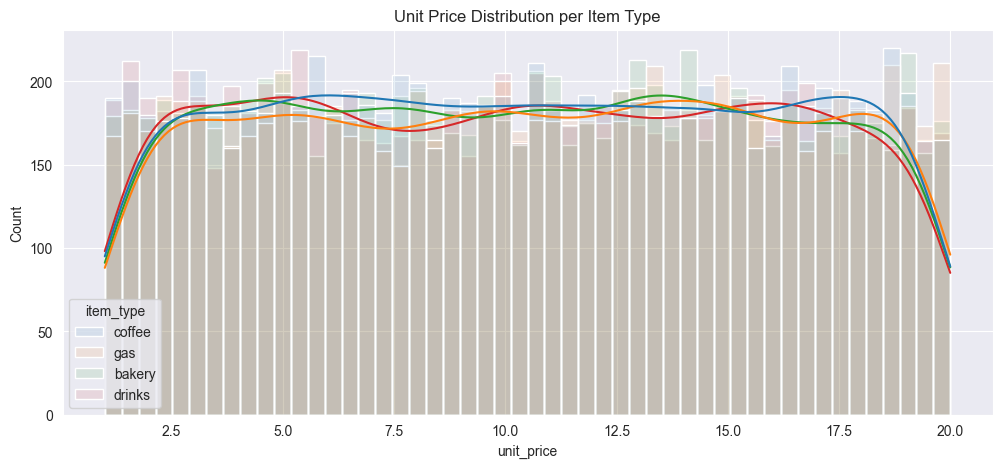

In [18]:
# Plot seaborn histogram of unit price per item type
plt.figure(figsize=(12, 5))
sns.histplot(data=transactions_cleaned, x='unit_price', hue='item_type', bins=50, kde=True, alpha=0.1)
plt.title('Unit Price Distribution per Item Type')
plt.show()

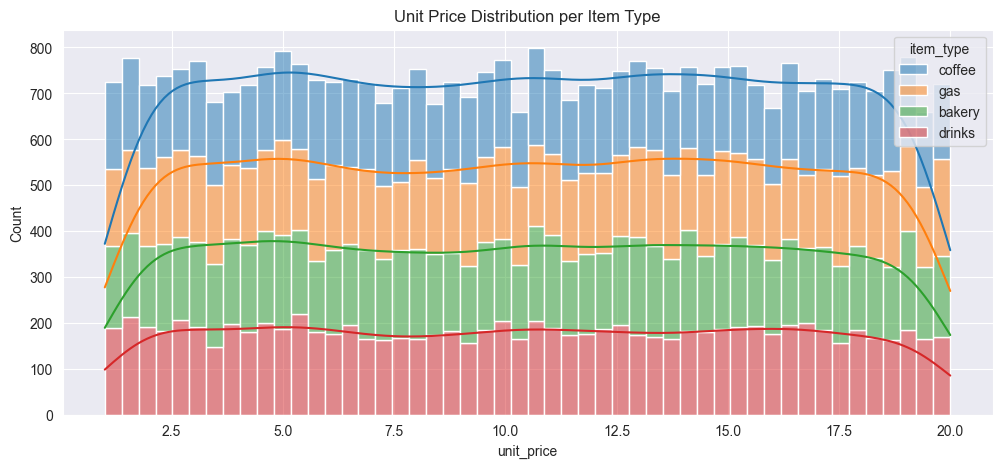

In [91]:
# Plot seaborn histogram of unit price per item type statcked
plt.figure(figsize=(12, 5))
sns.histplot(data=transactions_cleaned, x='unit_price', hue='item_type', bins=50, kde=True, multiple='stack')
plt.title('Unit Price Distribution per Item Type')
plt.show()

Based on what we did above each SKU don't have static price and their unit price changed randomly across distribution. So we cant compare them directly by using just statistical summary. We have to use statistical test like ANOVA to check if the price of each product is the same or not.

In [19]:
anova_results = {}

# Get unique item types
item_types = transactions_cleaned['item_type'].unique()

# Loop over each item_type
for item in item_types:
	df_subset = transactions_cleaned[transactions_cleaned['item_type'] == item]
	model = ols('unit_price ~ item', data=df_subset).fit()
	anova_table = sm.stats.anova_lm(model, typ=2)
	anova_results[item] = anova_table

for item in anova_results:
	print(f"ANOVA for item type {item}:\n", anova_results[item])

ANOVA for item type coffee:
             sum_sq      df    F  PR(>F)
item         61.43    3.00 0.68    0.56
Residual 279187.08 9290.00  NaN     NaN
ANOVA for item type gas:
             sum_sq      df    F  PR(>F)
item          9.64    1.00 0.32    0.57
Residual 272505.65 9008.00  NaN     NaN
ANOVA for item type bakery:
             sum_sq      df    F  PR(>F)
item        265.86    9.00 0.99    0.45
Residual 271837.22 9106.00  NaN     NaN
ANOVA for item type drinks:
             sum_sq      df    F  PR(>F)
item         68.14    2.00 1.13    0.32
Residual 274518.69 9077.00  NaN     NaN


It appears that there's no statistically significant difference in the unit prices for items within each item type category (p-value in the table under PR(>F) is more than 0.05).
**This means the average unit price for the different items within each category is approximately the same.**

**Assumption 1: Customers have varied preferences, equally on every product**

The similar sales numbers, total sale and unit price for different gas, drinks and coffees suggest that customers have a variety of preferences, and there's not a single dominant product in these categories. This can be interpreted as a positive sign of diversification or a negative sign of lack of focus, which marketing can be more challenging when there isn't a star product to emphasize. This might be difficult to craft a compelling marketing message that appeals to a broad range of tastes, make it difficult to stand out from the competition and build a loyal customer base.

**Suggestion**

- Product Focus: If there's no single dominant product, it could be beneficial to shift the focus onto the quality of some products. This could be done by sourcing high-quality ingredients like coffee beans or teas, improving preparation processes make it unique, or highlighting the craftsmanship of the baristas.
- Loyalty Program: Introducing a loyalty program can help in encouraging repeat purchases across the product line. Customers can be rewarded for trying different products or for consistent purchases, which could lead to increased sales across the SKU line.
- Product Bundling: To increase sales across categories, they could consider product bundling. For example, offering a coffee and a bakery item at a discounted price could encourage customers to buy more, while also introducing them to products they may not have tried otherwise.

We didn't check on time-related factor yet, so will check on that next.

### Time-related Sales Analysis

#### Weekday Sales

In [20]:
(
    transactions_cleaned
        .pivot_table(index='weekday'
                     , values='total_price'
                     , aggfunc=['count', 'sum', 'mean', 'median', 'std'])
        .reset_index()
)

,weekday,count,sum,mean,median,std
,,total_price,total_price,total_price,total_price,total_price
0,Friday,5157,147650.52,28.63,17.11,31.02
1,Monday,5279,150146.18,28.44,17.42,30.96
2,Saturday,5313,157768.95,29.69,18.14,31.71
3,Sunday,5164,146317.87,28.33,17.79,30.20
4,Thursday,5132,146820.31,28.61,17.10,31.32
5,Tuesday,5201,147223.38,28.31,17.11,30.58
6,Wednesday,5254,151293.18,28.80,17.38,30.94


<Axes: xlabel='weekday'>

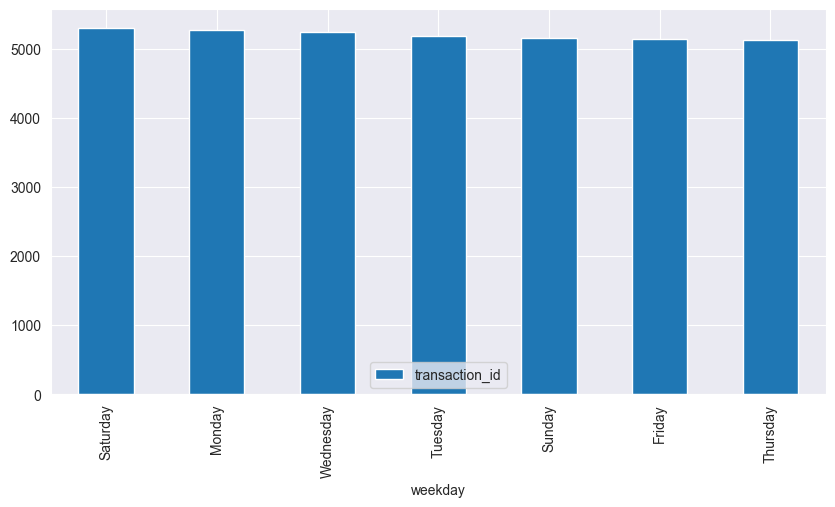

In [21]:
# check average total price  on weekdays
(
	transactions_cleaned
        .pivot_table(index='weekday'
                     , values='transaction_id'
                     , aggfunc='count')
        .reset_index()
        .sort_values('transaction_id', ascending=False)
        .plot
        .bar(x='weekday', y='transaction_id', figsize=(10, 5))
)

Same as total amount and total price of product sold, Not only the sum total price of product sold on weekdays are the same, almost every statistical metric also indicated that the sale on each weekday are likely to be the same.

Let's check total transaction for each weekday on each month.

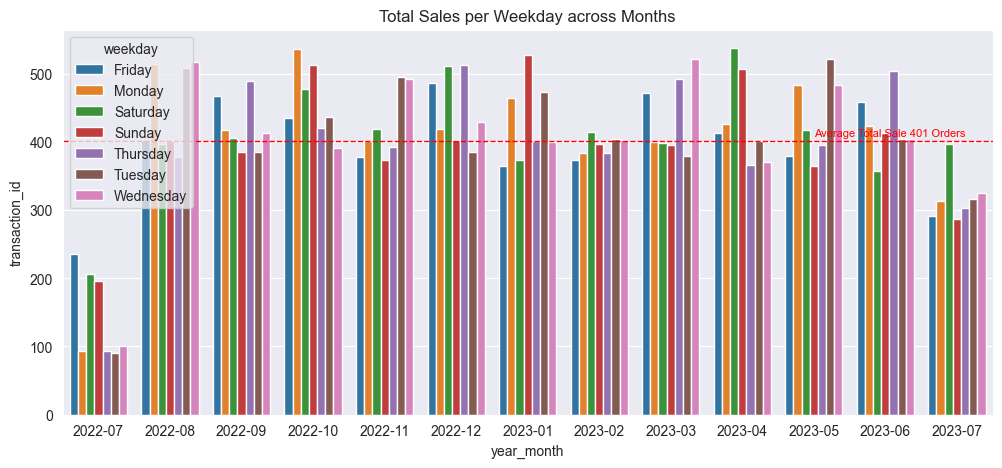

In [22]:
# check average total price  on weekdays
total_order_pivot = (
	transactions_cleaned
	.pivot_table(index=['year_month', 'weekday']
	             , values='transaction_id'
	             , aggfunc='count')
	.reset_index()
	.sort_values('year_month', ascending=True)
)

plt.figure(figsize=(12, 5))
sns.barplot(data=total_order_pivot, x='year_month', y='transaction_id', hue='weekday', errorbar=None)
# add average line
avg_total_order = total_order_pivot['transaction_id'].mean()
plt.axhline(y=avg_total_order, color='r', linestyle='--', linewidth=1)
# add text on average line
plt.text(x=10, y= avg_total_order * 1.02, s=f'Average Total Sale {round(avg_total_order)} Orders', color='r', fontsize=8)
plt.title('Total Sales per Weekday across Months')
plt.show()

In [89]:
order_time_summary = (
	transactions_cleaned
	.pivot_table(index=['year_month', 'item_type']
	             , values=['transaction_id', 'date', 'total_price']
	             , aggfunc={ "transaction_id": "count", "date": "nunique", "total_price": "sum"})
	.reset_index()
	.sort_values('year_month', ascending=True)
	.rename(columns={'transaction_id': 'total_order (time)'
        , 'date': 'total_day (day)'
        , 'total_price': 'total_sale (baht)'})
)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

# Line plot for 'total_order (time)' by 'item_type'
sns.lineplot(data=order_time_summary, x='year_month', y='total_order (time)', hue='item_type', ax=axes[0])
avg_total_order = order_time_summary['total_order (time)'].mean()
axes[0].axhline(y=avg_total_order, color='r', linestyle='--', linewidth=1)
axes[0].text(x=0, y=avg_total_order * 0.92, s=f'Average Total Order {round(avg_total_order)} Orders', color='r', fontsize=8)
axes[0].set_title('Total Order per Item Type across Months', fontsize=10)

# Line plot for 'total_sale (baht)' by 'item_type'
sns.lineplot(data=order_time_summary, x='year_month', y='total_sale (baht)', hue='item_type', ax=axes[1])
avg_total_sale = order_time_summary['total_sale (baht)'].mean()
axes[1].axhline(y=avg_total_sale, color='r', linestyle='--', linewidth=1)
axes[1].text(x=0, y=avg_total_sale * 0.92, s=f'Average Total Sale {round(avg_total_sale)} Baht', color='r', fontsize=8)
axes[1].set_title('Total Sale per Item Type across Months', fontsize=10)

# Line plot for 'total_day (day)' by 'item_type'
sns.lineplot(data=order_time_summary, x='year_month', y='total_day (day)', hue='item_type', ax=axes[2])
avg_total_day = order_time_summary['total_day (day)'].mean()
axes[2].axhline(y=avg_total_day, color='r', linestyle='--', linewidth=1)
axes[2].text(x=0, y=avg_total_day * 0.92, s=f'Average Total Day {round(avg_total_day)} Days', color='r', fontsize=8)
axes[2].set_title('Total Day per Item Type across Months', fontsize=10)


axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)

for ax in axes:
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

KeyError: 'date'

In [55]:
summary_total_price = transactions_cleaned.pivot_table(index='date'
                                                       , values='total_price'
                                                       , aggfunc='sum'
                                                       , margins=True).reset_index()

# Filter out the 'All' row
summary_total_price = summary_total_price[summary_total_price['date'] != 'All']

# Now you can convert the 'date' column to datetime
summary_total_price['date'] = pd.to_datetime(summary_total_price['date'])

summary_total_price


,date,total_price
0,2022-07-22,2661.71
1,2022-07-23,2352.29
2,2022-07-24,3312.00
3,2022-07-25,3071.47
4,2022-07-26,2815.62
...,...,...
361,2023-07-18,2757.30
362,2023-07-19,2914.59
363,2023-07-20,3050.74
364,2023-07-21,2708.59


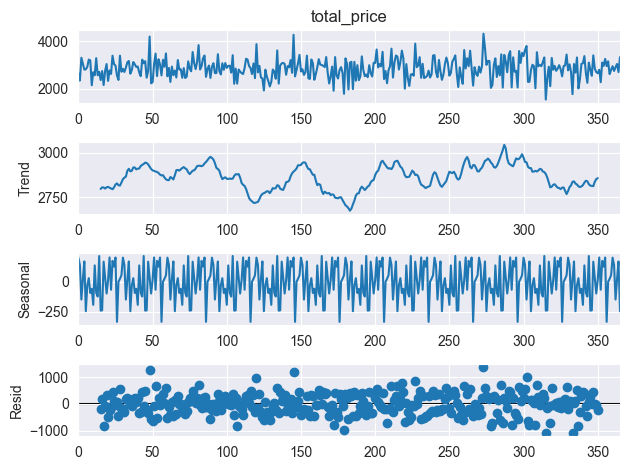

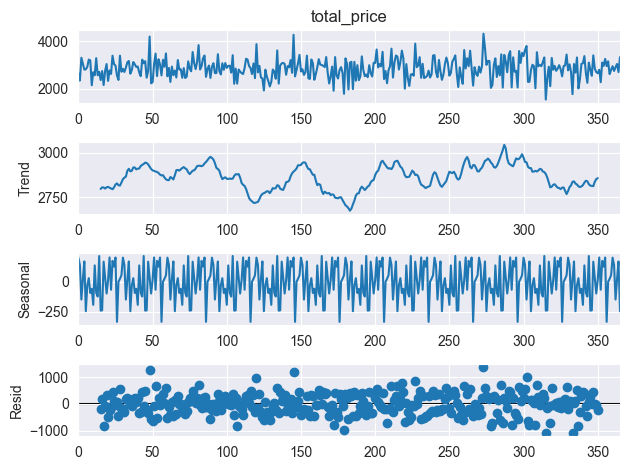

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

# find seasonality
decomposition = seasonal_decompose(summary_total_price['total_price'], model='additive', period=30)
decomposition.plot()

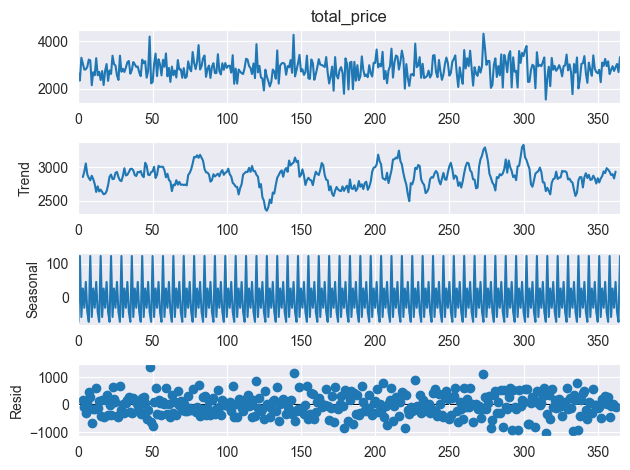

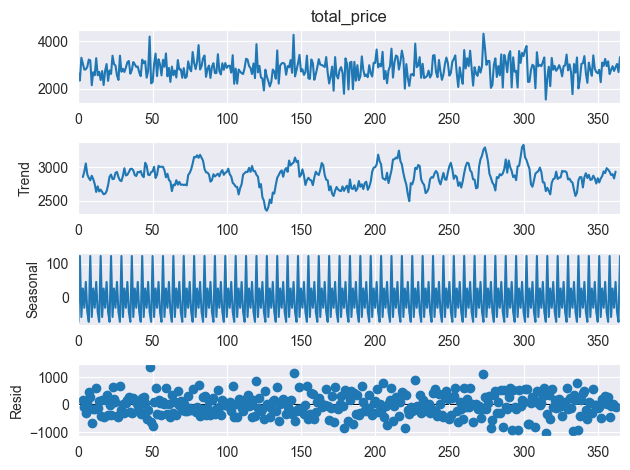

In [79]:
# find seasonality
decomposition = seasonal_decompose(summary_total_price['total_price'], model='additive', period=7)
decomposition.plot()

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(summary_total_price['total_price'], model='additive', period=30)

# Print the trend, seasonal, and residuals
print('Trend:', decomposition.trend)
print('Seasonal:', decomposition.seasonal)

Trend: 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
361   NaN
362   NaN
363   NaN
364   NaN
365   NaN
Name: trend, Length: 366, dtype: float64
Seasonal: 0      204.96
1      142.58
2     -148.34
3       22.68
4      173.09
        ...  
361    142.58
362   -148.34
363     22.68
364    173.09
365   -246.76
Name: seasonal, Length: 366, dtype: float64


In [24]:
# compare change of total sale between each year
(
	transactions_cleaned
    .pivot_table(index='year'
	             , values='date'
	             , aggfunc='nunique')
	.reset_index()
	.assign(change=lambda x: x['date'].pct_change() * 100)
	.fillna(0)
	.round(2)
	.assign(change=lambda x: x['change'].astype(str) + '%')
)

,year,date,change
0,2022,163,0.0%
1,2023,203,24.54%


In [25]:
# compare change of total sale between each year
(
    transactions_cleaned
    .pivot_table(index='year'
              , values='total_price'
              , aggfunc='sum')
    .reset_index()
    .assign(change=lambda x: x['total_price'].pct_change() * 100)
    .fillna(0)
    .round(2)
    .assign(change=lambda x: x['change'].astype(str) + '%')
 )

,year,total_price,change
0,2022,465663.22,0.0%
1,2023,581557.17,24.89%


In [26]:
# compare change of total sale between each year
(
    transactions_cleaned
    .pivot_table(index='year'
              , values='item'
              , aggfunc='count')
    .reset_index()
    .assign(change=lambda x: x['item'].pct_change() * 100)
    .fillna(0)
    .round(2)
    .assign(change=lambda x: x['change'].astype(str) + '%')
 )

,year,item,change
0,2022,16410,0.0%
1,2023,20090,22.43%


In [27]:
# compare change of total sale between each year
(
    transactions_cleaned
        .pivot_table(index='year'
                  , values='discount'
                  , aggfunc='mean')
        .reset_index()
        .assign(change=lambda x: x['discount'].pct_change() * 100)
        .fillna(0)
        .round(2)
        .assign(change=lambda x: x['change'].astype(str) + '%')
)

,year,discount,change
0,2022,0.50,0.0%
1,2023,0.50,-0.88%


In [28]:
# compare change of total sale between each year
(
	transactions_cleaned
	.pivot_table(index='year'
	             , values='unit_price'
	             , aggfunc='mean')
	.reset_index()
	.assign(change=lambda x: x['unit_price'].pct_change() * 100)
	.fillna(0)
	.round(2)
	.assign(change=lambda x: x['change'].astype(str) + '%')
)

,year,unit_price,change
0,2022,10.43,0.0%
1,2023,10.50,0.73%


In [29]:
(
    transactions_cleaned
    .pivot_table(index=['payment_method', 'item_type']
                 , values='total_price'
                 , aggfunc=['sum', 'mean', 'count'])
    .reset_index()
    .sort_values(('sum', 'total_price'), ascending=True)
)

,payment_method,item_type,sum,mean,count
,,,total_price,total_price,total_price
6,credit card,drinks,83281.05,28.30,2943
10,qr code,drinks,84540.06,27.65,3057
8,qr code,bakery,84998.14,28.57,2975
3,cash,gas,85252.66,28.94,2946
7,credit card,gas,86028.52,28.72,2995
4,credit card,bakery,87909.58,28.51,3083
0,cash,bakery,88534.27,28.95,3058
2,cash,drinks,88742.62,28.81,3080
9,qr code,coffee,88849.35,29.12,3051


**Assumption 2: This gas station has reach its capacity in production**

The similar sales numbers, total sale and unit price for different gas, drinks and coffees in both individual quantity along with the same trend in the same period of time could be an indication that this gas station has reached its capacity in production.

**Suggestion**

- **Operational Efficiency:** Review your operations to identify any bottlenecks or inefficiencies. Small adjustments in how the gas station operates may help increase throughput without a significant additional investment. For example, optimizing shift schedules or improving processes at the gas pumps, coffee station, or bakery could increase capacity.

- **Invest in Capacity Expansion:** If the demand is there and you're limited by your current setup, it might be worthwhile to consider investing in additional equipment or facilities to increase capacity. For instance, additional coffee machines, bakery ovens, or even gas pumps could be installed.

- **Pricing Strategy:** Consider implementing dynamic pricing or surge pricing during peak hours to increase revenue without having to expand capacity. Higher prices during high demand periods can help regulate the flow of customers and maximize profits.

- **Partnership or Outsourcing:** Consider partnering with external vendors or outsourcing certain parts of your operations. For example, you might want to consider having a bakery vendor deliver fresh pastries daily, which would allow you to meet the demand without needing to produce everything in-house.

- **Extend Operating Hours:** If feasible, extending operating hours can help spread customer demand over a longer period and utilize the existing capacity more effectively.

**Assumption 3: This gas station choose to have similar profitability on every product**

Similar profitability across such different product categories could raise some concerns and opportunities:

- **Missed Profit Maximization:** While similar profit across different categories simplifies accounting and inventory management, it might mean that the business is not fully capitalizing on the profitability of certain items. Products with higher demand or higher perceived value might be able to sustain higher prices.

- **Market Segmentation:** The business might not be fully considering the different market segments for its product categories. Different strategies could be applied to each product category to maximize their individual profitability.

**Suggestion**

- **Re-evaluate Pricing Strategy**: Conduct a thorough analysis of each product's cost structure, demand elasticity, competitive landscape, and perceived value. This can provide insights on which items have the potential to yield higher profit margins. For instance, specialty coffee drinks might have a higher perceived value and could be priced higher compared to regular coffee, leading to an increase in profitability.

- **Targeted Marketing & Promotions**: Develop marketing strategies and promotions tailored to different product categories or specific SKUs. For example, if bakery items are found to have a higher potential profit margin, these could be promoted more heavily, perhaps in combination with high-demand products like coffee in a "meal deal".

- **Dynamic Pricing**: Implementing dynamic pricing during peak hours or high-demand periods can also help increase profitability without necessarily increasing sales volume.

**Assumption 4: Stable Customer base**

Due to we didn't know who buy our product but base on stable sales number and total sale, we can assume that the customer base is stable. But this can go in two ways
1. The customer is stable due to there are no customer churn but also no new customer as well
2. The customer is stable due to new customer and customer churn are the same

**Suggestion**
there could indeed be possible suggestion based on both scenarios:

1. **Stable Customer Base With No Churn or New Customers**:

   - **Customer Retention Strategies**: Since your customer base is loyal, it could be beneficial to introduce a loyalty program if you haven't already. This could incentivize repeat purchases, and possibly increase the average transaction value.

   - **Upselling and Cross-selling**: Given that your customers are regulars, it would be good to introduce more upselling and cross-selling strategies, perhaps promoting products that they don't usually buy.

   - **Customer Feedback**: Ask for their feedback to understand what other products or services they might be interested in. This can help you diversify or personalize your offerings, potentially increasing sales.

2. **Stable Customer Base with Equal Churn and Acquisition**:

   - **Customer Retention**: Investigate why customers are leaving. Collect feedback from customers who have stopped visiting your store to understand what you can improve.
   - **Customer Satisfaction Surveys**: Regularly conduct customer satisfaction surveys to gauge how well you're meeting customer expectations. Identifying issues early can help prevent customer churn.
   - **Competitive Analysis**: Keep an eye on what competitors are doing that might be drawing your customers away, and consider whether you should adjust your strategy.
   - **New Customer Onboarding**: For new customers, ensure that the onboarding experience is positive. This could include great service, clear signage for product locations, or even an introductory offer.

### Discount Rate Optimization
We've noted that about 80% of customers receive a discount rate greater than 20%. Given that most coffee shops operate on profit margins of around [2.5%-6.8%](https://bellwethercoffee.com/blog/the-complete-guide-to-coffee-shop-profit-margins-and-how-to-raise-them/), and without information on our product cost, we must assume that this coffee shop has been in an unprofitable phase for over a year.

**Suggestions:**

Consider refraining from offering discounts to most customers. While a high discount rate can help maintain or strengthen your customer base, excessive discounting could devalue your product and lessen its uniqueness. This can make marketing campaigns more challenging, as the high baseline discount in normal circumstances is not beneficial for business.

If optimizing the discount rate is not appealing due to the risk of customer churn (especially if the store has maintained this discount strategy for an extended period), consider reducing the cost of each product. For instance, with coffee drinks, using in-house coffee blends could reduce expenses.

In [83]:
# average discount rate
(
    transactions_cleaned
        .pivot_table(index=['item_type']
                     , values='discount'
                     , aggfunc='mean')
        .reset_index()
        .sort_values('discount', ascending=False)
)

,item_type,discount
3,gas,0.50
0,bakery,0.50
2,drinks,0.50
1,coffee,0.50


Text(0, 0.5, 'Count')

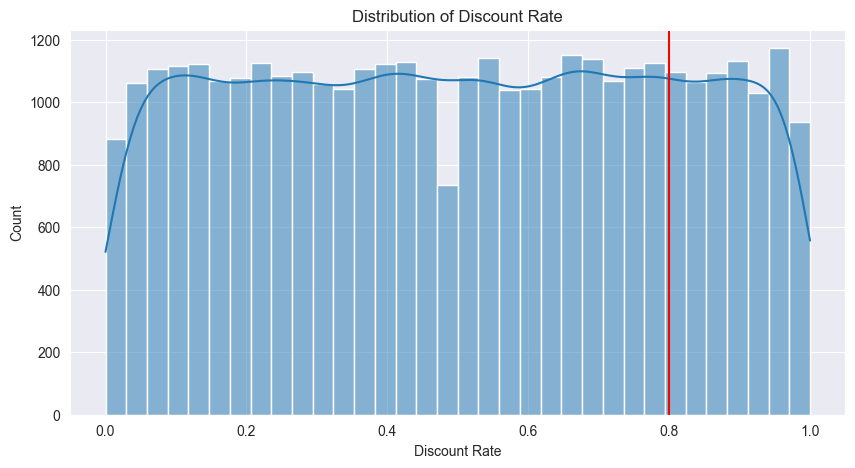

In [84]:
# plot histogram of discount rate seaborn
plt.figure(figsize=(10, 5))
sns.histplot(transactions_cleaned['discount'], kde=True)
plt.title('Distribution of Discount Rate')

# add line vertical at 0.8
plt.axvline(x=0.8, color='red')
plt.xlabel('Discount Rate')
plt.ylabel('Count')

In [85]:
round(len(transactions_cleaned.query("discount > 0.2")) / transactions_cleaned.shape[0] * 100)

80

### Extra Suggestions

#### Transaction Data Log:
Currently, our transaction schema only tracks one SKU per transaction. This does not account for instances when customers purchase more than one product per transaction, hindering our ability to perform bucket analysis or observe other purchase behaviors valuable for marketing campaigns or product recommendations.

**Suggestion:**
Consider introducing a "transaction_id" column. This key indicator could represent the same transaction, allowing for the logging of multiple products per transaction.


#### Discount Rate Calculation

Miscalculation of the discount rate could lead to inaccurate insights. But this is not just technical problem of python we mention before, on business owner side we have make sure that is calculation will be done on cashier size or on database depend on the constraint this business have.

---